In [1]:
#%%
from pathlib import Path

import numpy as np
import snapatac2 as snap
from gcell._settings import get_setting

annotation_dir = get_setting('annotation_dir')
print("gcell currently using annotation directory:", annotation_dir)


gcell currently using annotation directory: /home/xf2217/.gcell_data/annotations


# Data Preparation Tutorial from SnapATAC2 / Cell Ranger

This tutorial demonstrates how to prepare single-cell multiome (RNA + ATAC) data for GET model training.

We'll use the PBMC10k dataset from 10x Genomics as an example.



## Overview:

1. Process RNA data - normalize, filter for highly variable genes

2. Process ATAC data - compute spectral embedding

3. Filter for abundant cell types

4. Generate peak accessibility and gene expression files for each cell type

## 0. Download cellranger-ARC processed data from 10x
```bash
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5"
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz"
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz.tbi"
wget "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peaks.bed"
wget "http://catlas.org/catlas_downloads/humantissues/cCRE_hg38.tsv.gz"
```

In [2]:
import pandas as pd
from pyranges import PyRanges as pr

cre = pd.read_csv('cCRE_hg38.tsv.gz', sep='\t')
cre = cre.rename(columns={'#Chromosome': 'Chromosome', 'hg38_Start': 'Start', 'hg38_End': 'End'})[['Chromosome', 'Start', 'End']]
cre = pr(cre, int64=True).sort()

In [3]:
import scanpy as sc

ad = sc.read_10x_h5('pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
ad

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11898 × 180488
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

This hdf5 contains the count matrix for both gene expression and peak count.
We can have a look at the peaks called by cellranger.

In [5]:

peaks = ad.var.query('feature_types == "Peaks"').interval.str.split(':|-').tolist()
peaks = pd.DataFrame(peaks, columns=['Chromosome', 'Start', 'End'])
peaks['Start'] = peaks['Start'].astype(int)
peaks['End'] = peaks['End'].astype(int)
peaks = pr(peaks, int64=True).sort()
peaks.df.shape


(143887, 3)

> Note: For optimal zero-shot analysis, it is recommended to use a union set of peaks 
> from both the new dataset and the original training peak sets (i.e. the cre peaks 
> defined above) to minimize domain shift. However, in this tutorial we will simply 
> perform finetuning using the new peak set from the 10x PBMC multiome data.
> The union peak set can be constructed as below. After that you should re-count the peak count
> matrix using fragment file, and when write out cell-type specific peaks, ideally remove all non-accessible peaks in
> each cell types.

In [7]:

# peak / cre + cre 
# find all peaks that don't overlap with cre; -> non_overlap_peaks
non_overlap_peaks = peaks.overlap(cre, invert=True)
# concat with cre and sort
total_peaks = pd.concat([non_overlap_peaks.df, cre.df], ignore_index=True)
total_peaks = pr(total_peaks, int64=True).sort()
# remove chromosome M, Y and those not start with chr
total_peaks = total_peaks.df.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
total_peaks.shape


(1164363, 3)

For convenience, we will keep using the peak set called by cellranger here。 Note that there is a difference in peak length distribution. However, in general there are no peaks > 1000 bp; and most peaks have a length in order of $10^3$ so let's keep using this one. Note that the original training CRE peak set has a unified length of 400 bp.

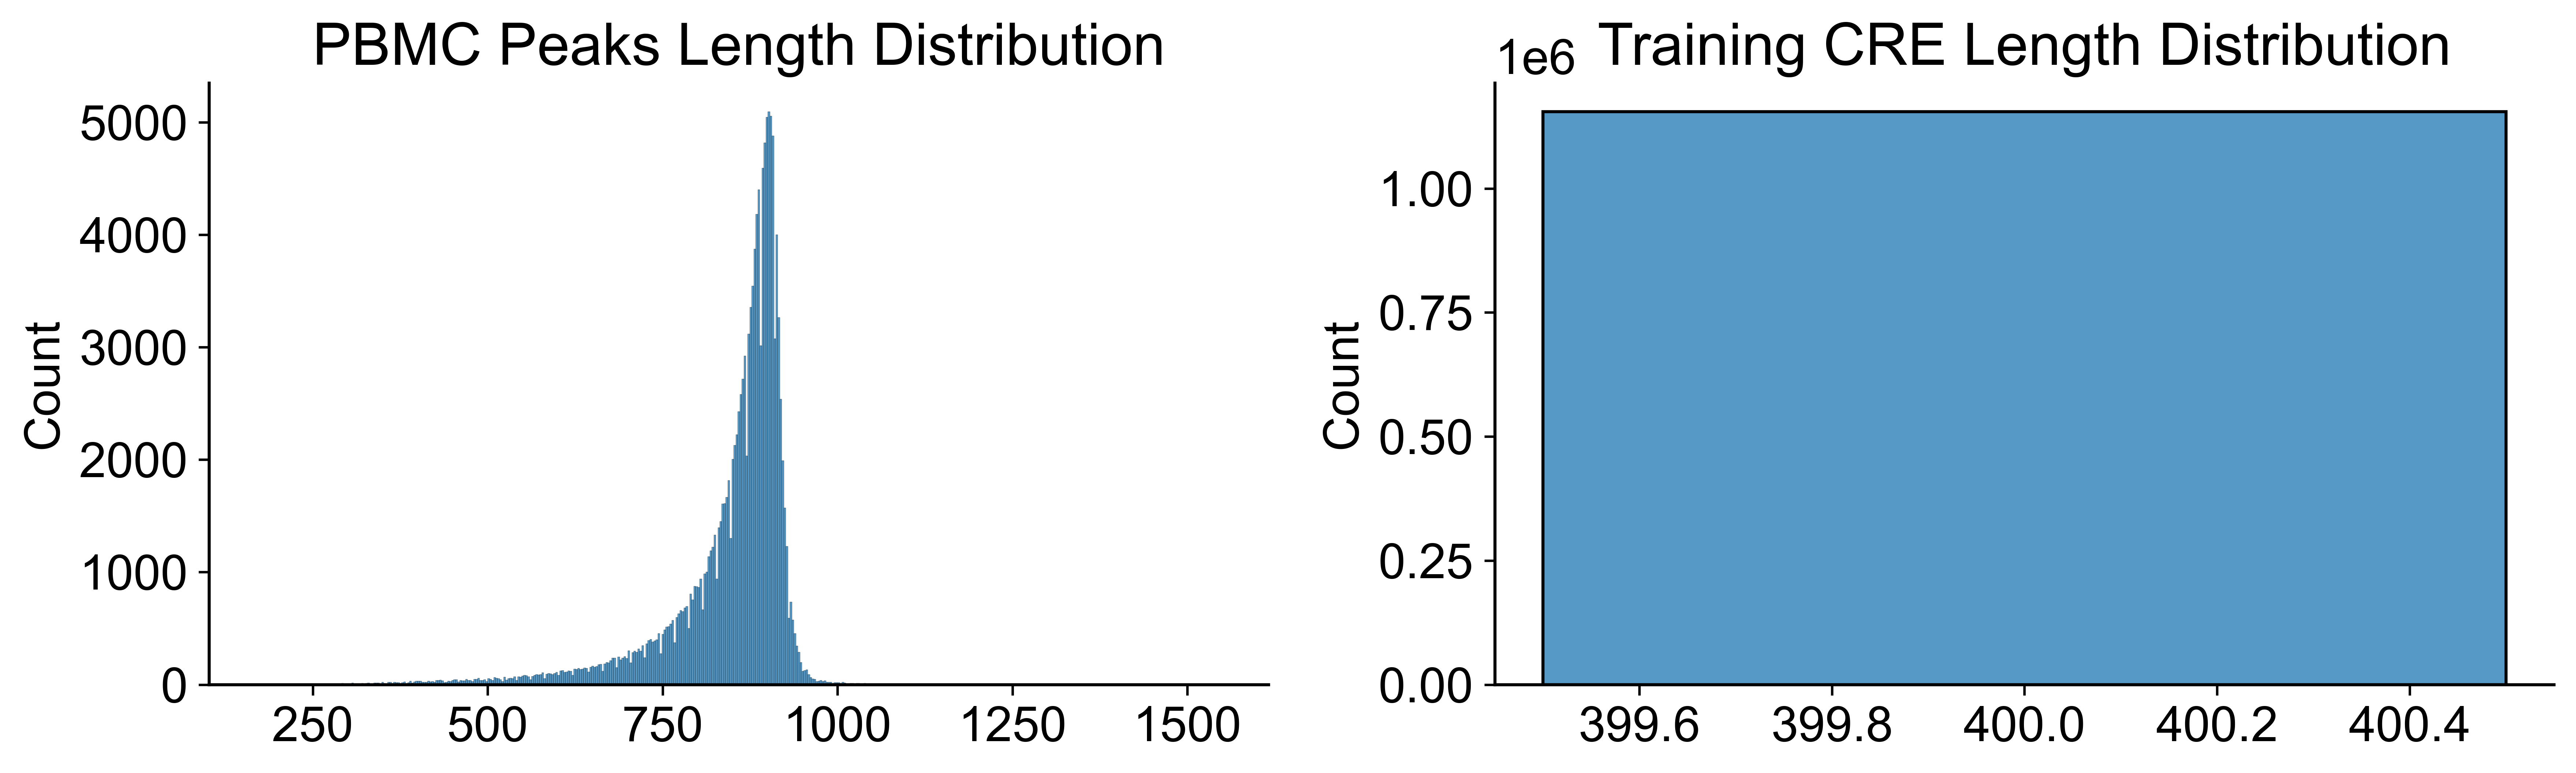

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# sns.histplot(peaks.End-peaks.Start, ax=ax1)
# ax1.set_title('PBMC Peaks Length Distribution')

# sns.histplot(cre.End-cre.Start, ax=ax2)  
# ax2.set_title('Training CRE Length Distribution')

# plt.tight_layout()


## 1. Cell type assignment

- Load RNA data from processed PBMC10k dataset and borrow the labels. If you have your own cell type labels on the data, skip this step.

- Select top 3000 highly variable genes and perform UMAP to cross check with assigned labels.


In [6]:
# %%
# read rna data
if not Path('rna.h5ad').exists():
    rna = snap.read(snap.datasets.pbmc10k_multiome(modality='RNA'), backed=None)
    sc.pp.highly_variable_genes(rna, flavor='seurat_v3', n_top_genes=3000)
    rna_filtered = rna[:, rna.var.highly_variable]
    sc.pp.normalize_total(rna_filtered, target_sum=1e4)
    sc.pp.log1p(rna_filtered)
    snap.tl.spectral(rna_filtered, features=None)
    snap.tl.umap(rna_filtered)
    rna_filtered.write('rna.h5ad')
else:
    rna_filtered = sc.read('rna.h5ad')

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Here, I'm going to use the cell type labels from preprocessed snapatac2 object.

In [10]:
ad = ad[ad.obs.index.isin(rna_filtered.obs.index.values)]

In [11]:
barcode_to_celltype = rna_filtered.obs.to_dict()['cell_type']
ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)


/tmp/ipykernel_48922/1270784820.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['cell_type'] = ad.obs.index.map(barcode_to_celltype)
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
ad.obs.head()

,cell_type
AAACAGCCAATCCCTT-1,CD4 TCM
AAACAGCCAATGCGCT-1,CD4 Naive
AAACAGCCACCAACCG-1,CD8 Naive
AAACAGCCAGGATAAC-1,CD4 Naive
AAACAGCCAGTTTACG-1,CD4 TCM


In [13]:
ad_rna = ad[:, np.where(ad.var.feature_types == 'Gene Expression')[0]]
ad_rna

View of AnnData object with n_obs × n_vars = 9627 × 36601
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

Let's calculate the umap on the ad_rna and compare the clustering with assigned cell type labels. In your own analysis, if you already have the labels, you can skip this.

/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/xf2217/.local/share/hatch/env/virtual/get-model/3YXmUFLM/get-model/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_

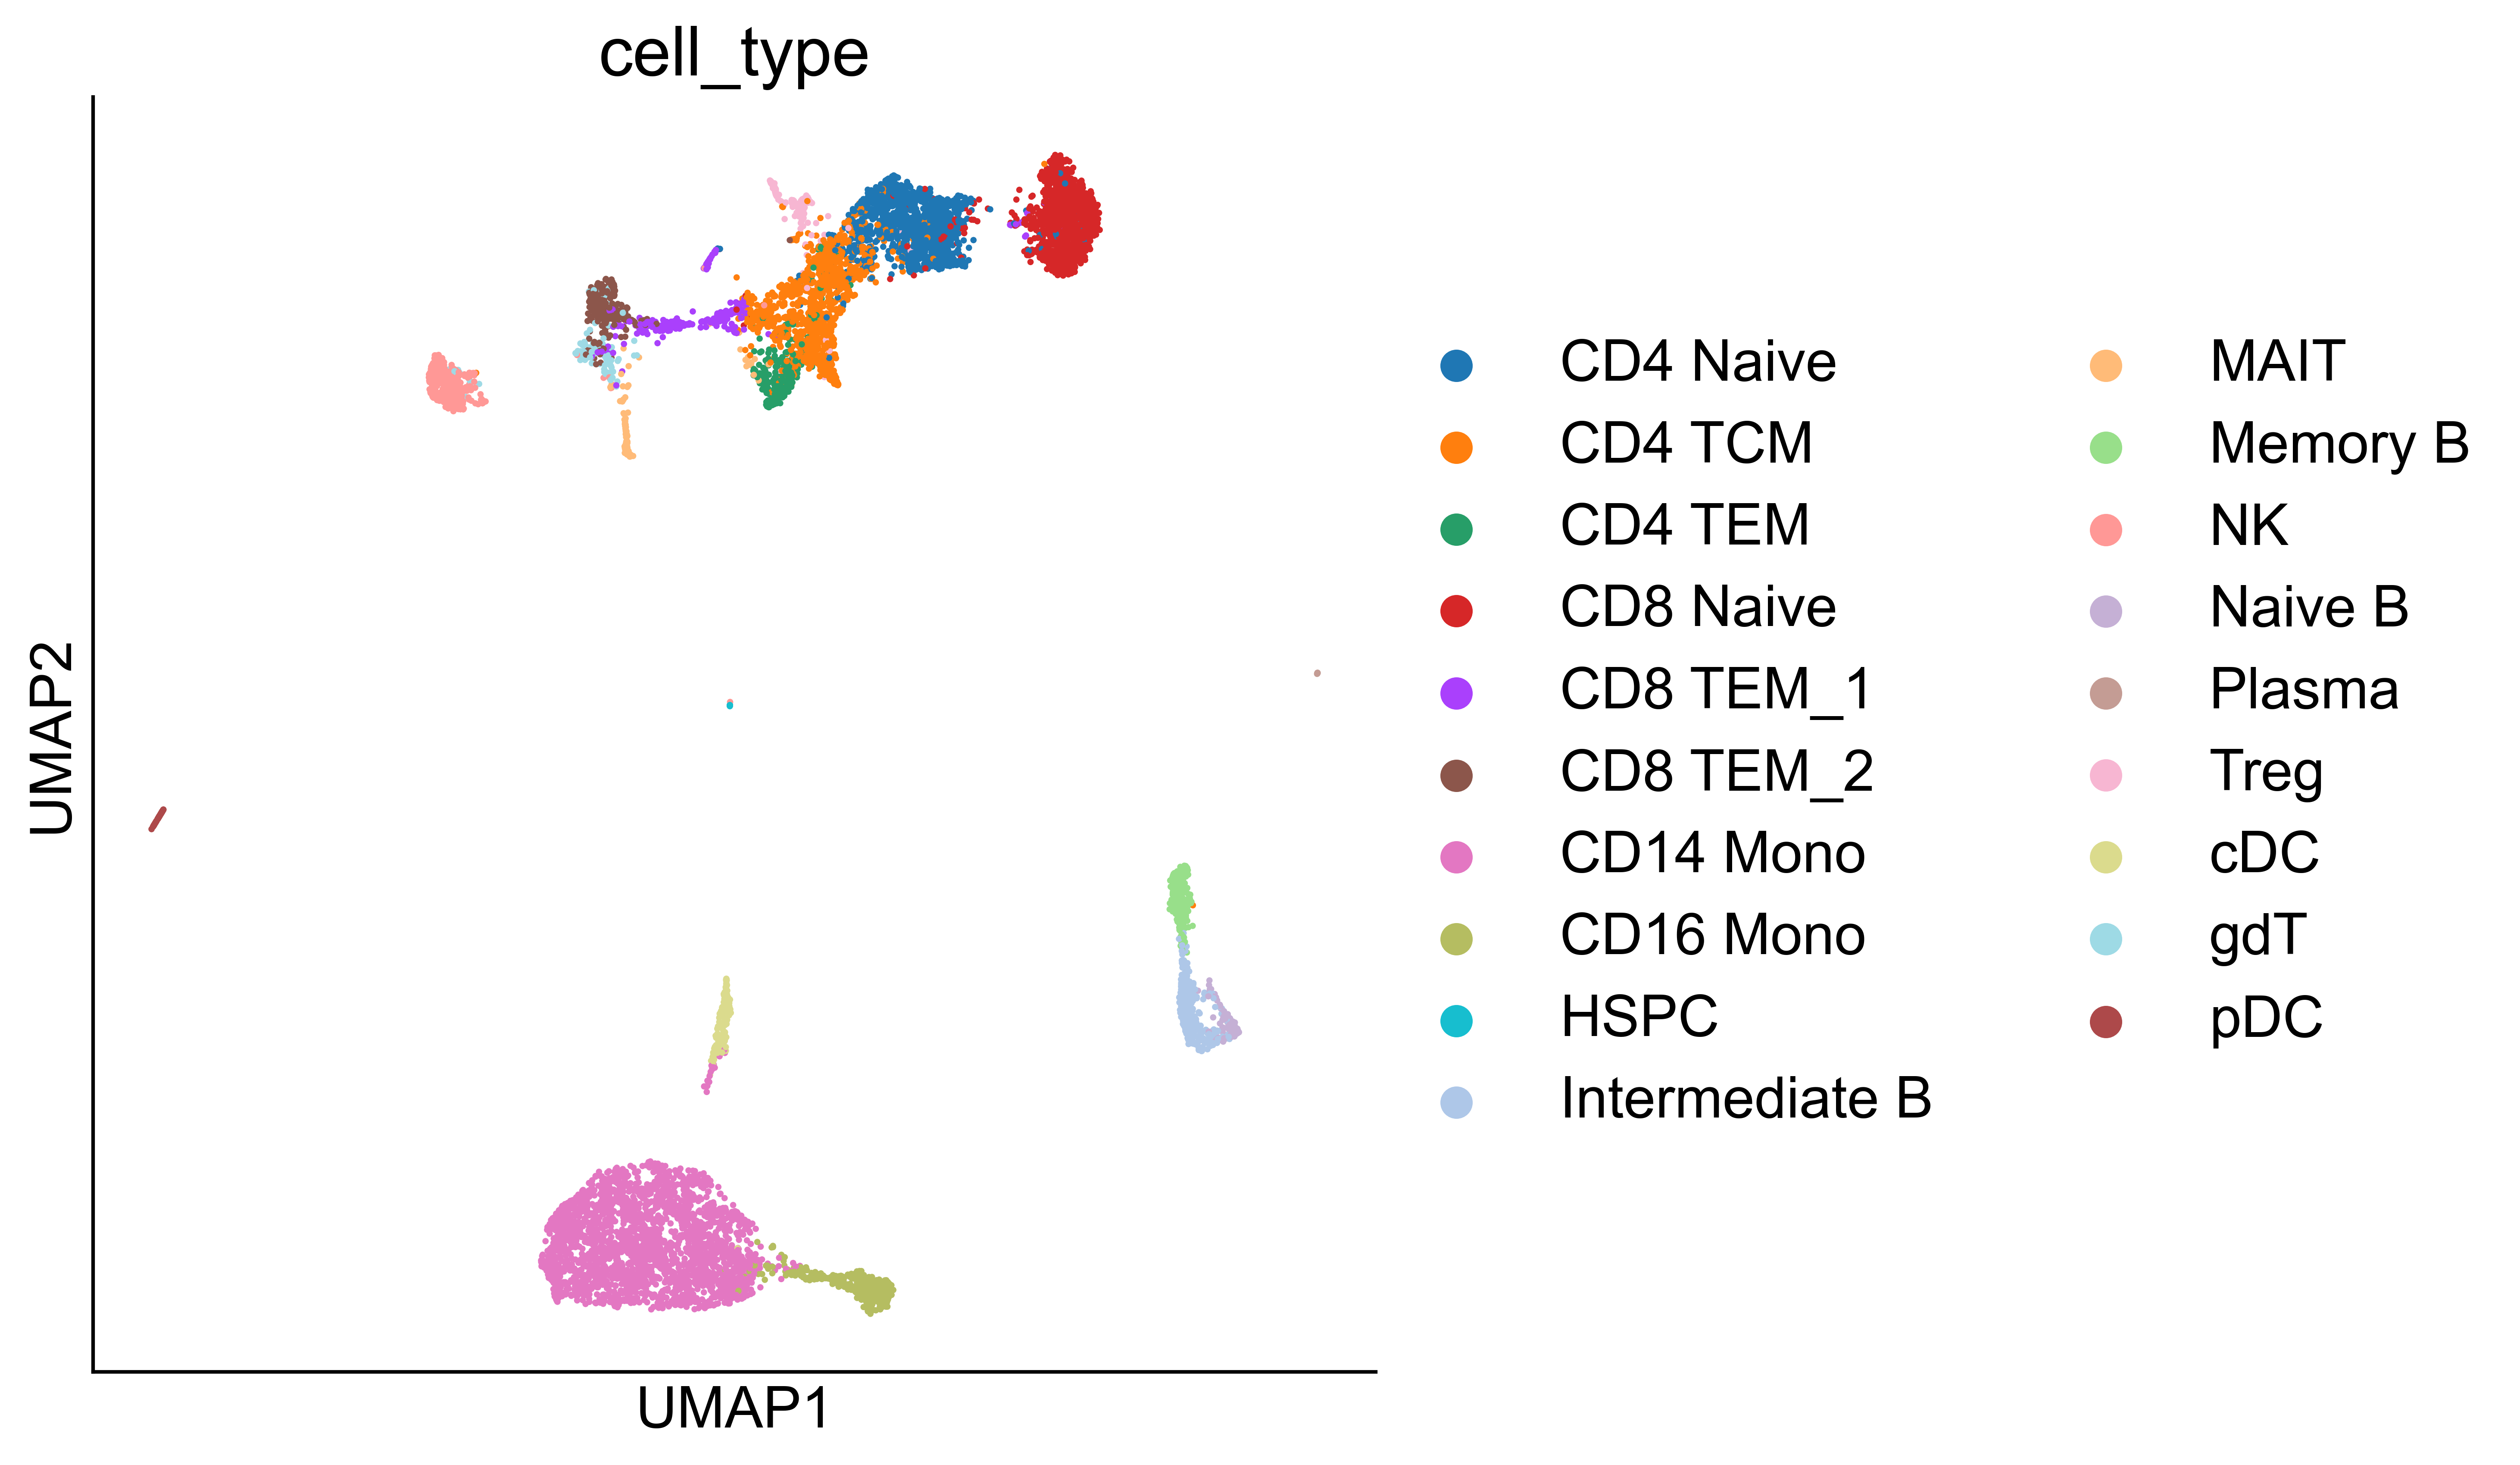

In [14]:

sc.pp.highly_variable_genes(ad_rna, flavor='seurat_v3', n_top_genes=3000)
ad_rna_filtered = ad_rna[:, ad_rna.var.highly_variable]
sc.pp.normalize_total(ad_rna_filtered, target_sum=1e4)
sc.pp.log1p(ad_rna_filtered)
snap.tl.spectral(ad_rna_filtered, features=None)
snap.tl.umap(ad_rna_filtered)
sc.pl.umap(ad_rna_filtered, color='cell_type')


It seems the cell types match well with the data. So now let's collect the ATAC object and look at library sizes of different cell types. Note that if you have a very densely sampled dataset, you can also perform metacell analysis and sample pseudobulk with a consistent library size.

In [15]:
ad_atac = ad[:, np.where(ad.var.feature_types == 'Peaks')[0]]
ad_atac

View of AnnData object with n_obs × n_vars = 9627 × 143887
    obs: 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

We filter for cell types with >100 cells and at least 3M library size.

The selected cell types will be used for training GET models.

In [16]:
# %%

cell_number = ad_atac.obs.groupby('cell_type', observed=False).size().to_dict()
print("The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling")
celltype_for_modeling = []
for cell_type in cell_number:
    if cell_number[cell_type] > 100:
        celltype_for_modeling.append(cell_type)
        libsize = int(ad_atac[ad_atac.obs.cell_type == cell_type].X.sum())
        if libsize > 3000000:
            print(f"{cell_type} number of cells: {cell_number[cell_type]}, library size: {libsize}")

The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling
CD14 Mono number of cells: 2551, library size: 62039712
CD16 Mono number of cells: 442, library size: 10504281
CD4 Naive number of cells: 1382, library size: 29601700
CD4 TCM number of cells: 1113, library size: 24745884
CD4 TEM number of cells: 286, library size: 6965094
CD8 Naive number of cells: 1353, library size: 30763516
CD8 TEM_1 number of cells: 322, library size: 7209424
CD8 TEM_2 number of cells: 315, library size: 6378479
Intermediate B number of cells: 300, library size: 8366581
MAIT number of cells: 130, library size: 3290943
Memory B number of cells: 298, library size: 7267452
NK number of cells: 403, library size: 8665433
Naive B number of cells: 125, library size: 3618917
Treg number of cells: 157, library size: 3135736
cDC number of cells: 180, library size: 6102032
gdT number of cells: 143, library size: 3106695


## 2. Export training data
For each abundant cell type, we'll generate:
1. Peak accessibility file (.atac.bed) containing:
   - Peak coordinates (chr, start, end)
   - Normalized accessibility scores (aCPM, $10^5$ scale factor)
2. Gene expression file (.rna.csv) containing:
   - Gene names
   - Normalized expression values (TPM, $10^6$ scale factor)


In [17]:
# This should be the same as the peaks variable defined above.
import pandas as pd
from pyranges import PyRanges as pr
def get_peak_from_snapatac(atac: snap.AnnData):
    """
    Get the peak names from the snapatac object.

    Args:
        atac: snapatac2 processed AnnData object

    Returns:
        peak_names: pandas DatasFrame with the peak names
    """
    peak_names = pd.DataFrame(atac.var.index.str.split('[:-]').tolist(), columns=['Chromosome', 'Start', 'End'])
    peak_names['Start'] = peak_names['Start'].astype(int)
    peak_names['End'] = peak_names['End'].astype(int)
    return peak_names

peaks = get_peak_from_snapatac(ad_atac)
peaks.shape

(143887, 3)

In [18]:
# %%
def get_peak_acpm_for_cell_type(atac: snap.AnnData, cell_type: str):
    """
    Get the peak acpm for a given cell type.
    """
    peaks = get_peak_from_snapatac(atac)
    counts = np.array(atac[atac.obs.cell_type == cell_type].X.sum(0)).flatten()
    acpm = np.log10(counts / counts.sum() * 1e5 + 1)
    peaks['aCPM'] = acpm/acpm.max()
    peaks = peaks.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
    peaks = pr(peaks, int64=True).sort().df
    return peaks

Let's run the function above to save the peak with aCPM for all cell types. Note that here we use the common peak set for all cell types. Later in the dataset we will be able to filter out peaks with no accessibility for each cell type.

In [19]:
# %%
for cell_type in celltype_for_modeling:
    peaks = get_peak_acpm_for_cell_type(ad_atac, cell_type)
    peaks.to_csv(f'{cell_type.replace(" ", "_").lower()}.atac.bed', sep='\t', index=False, header=False)

<Axes: xlabel='aCPM', ylabel='length'>

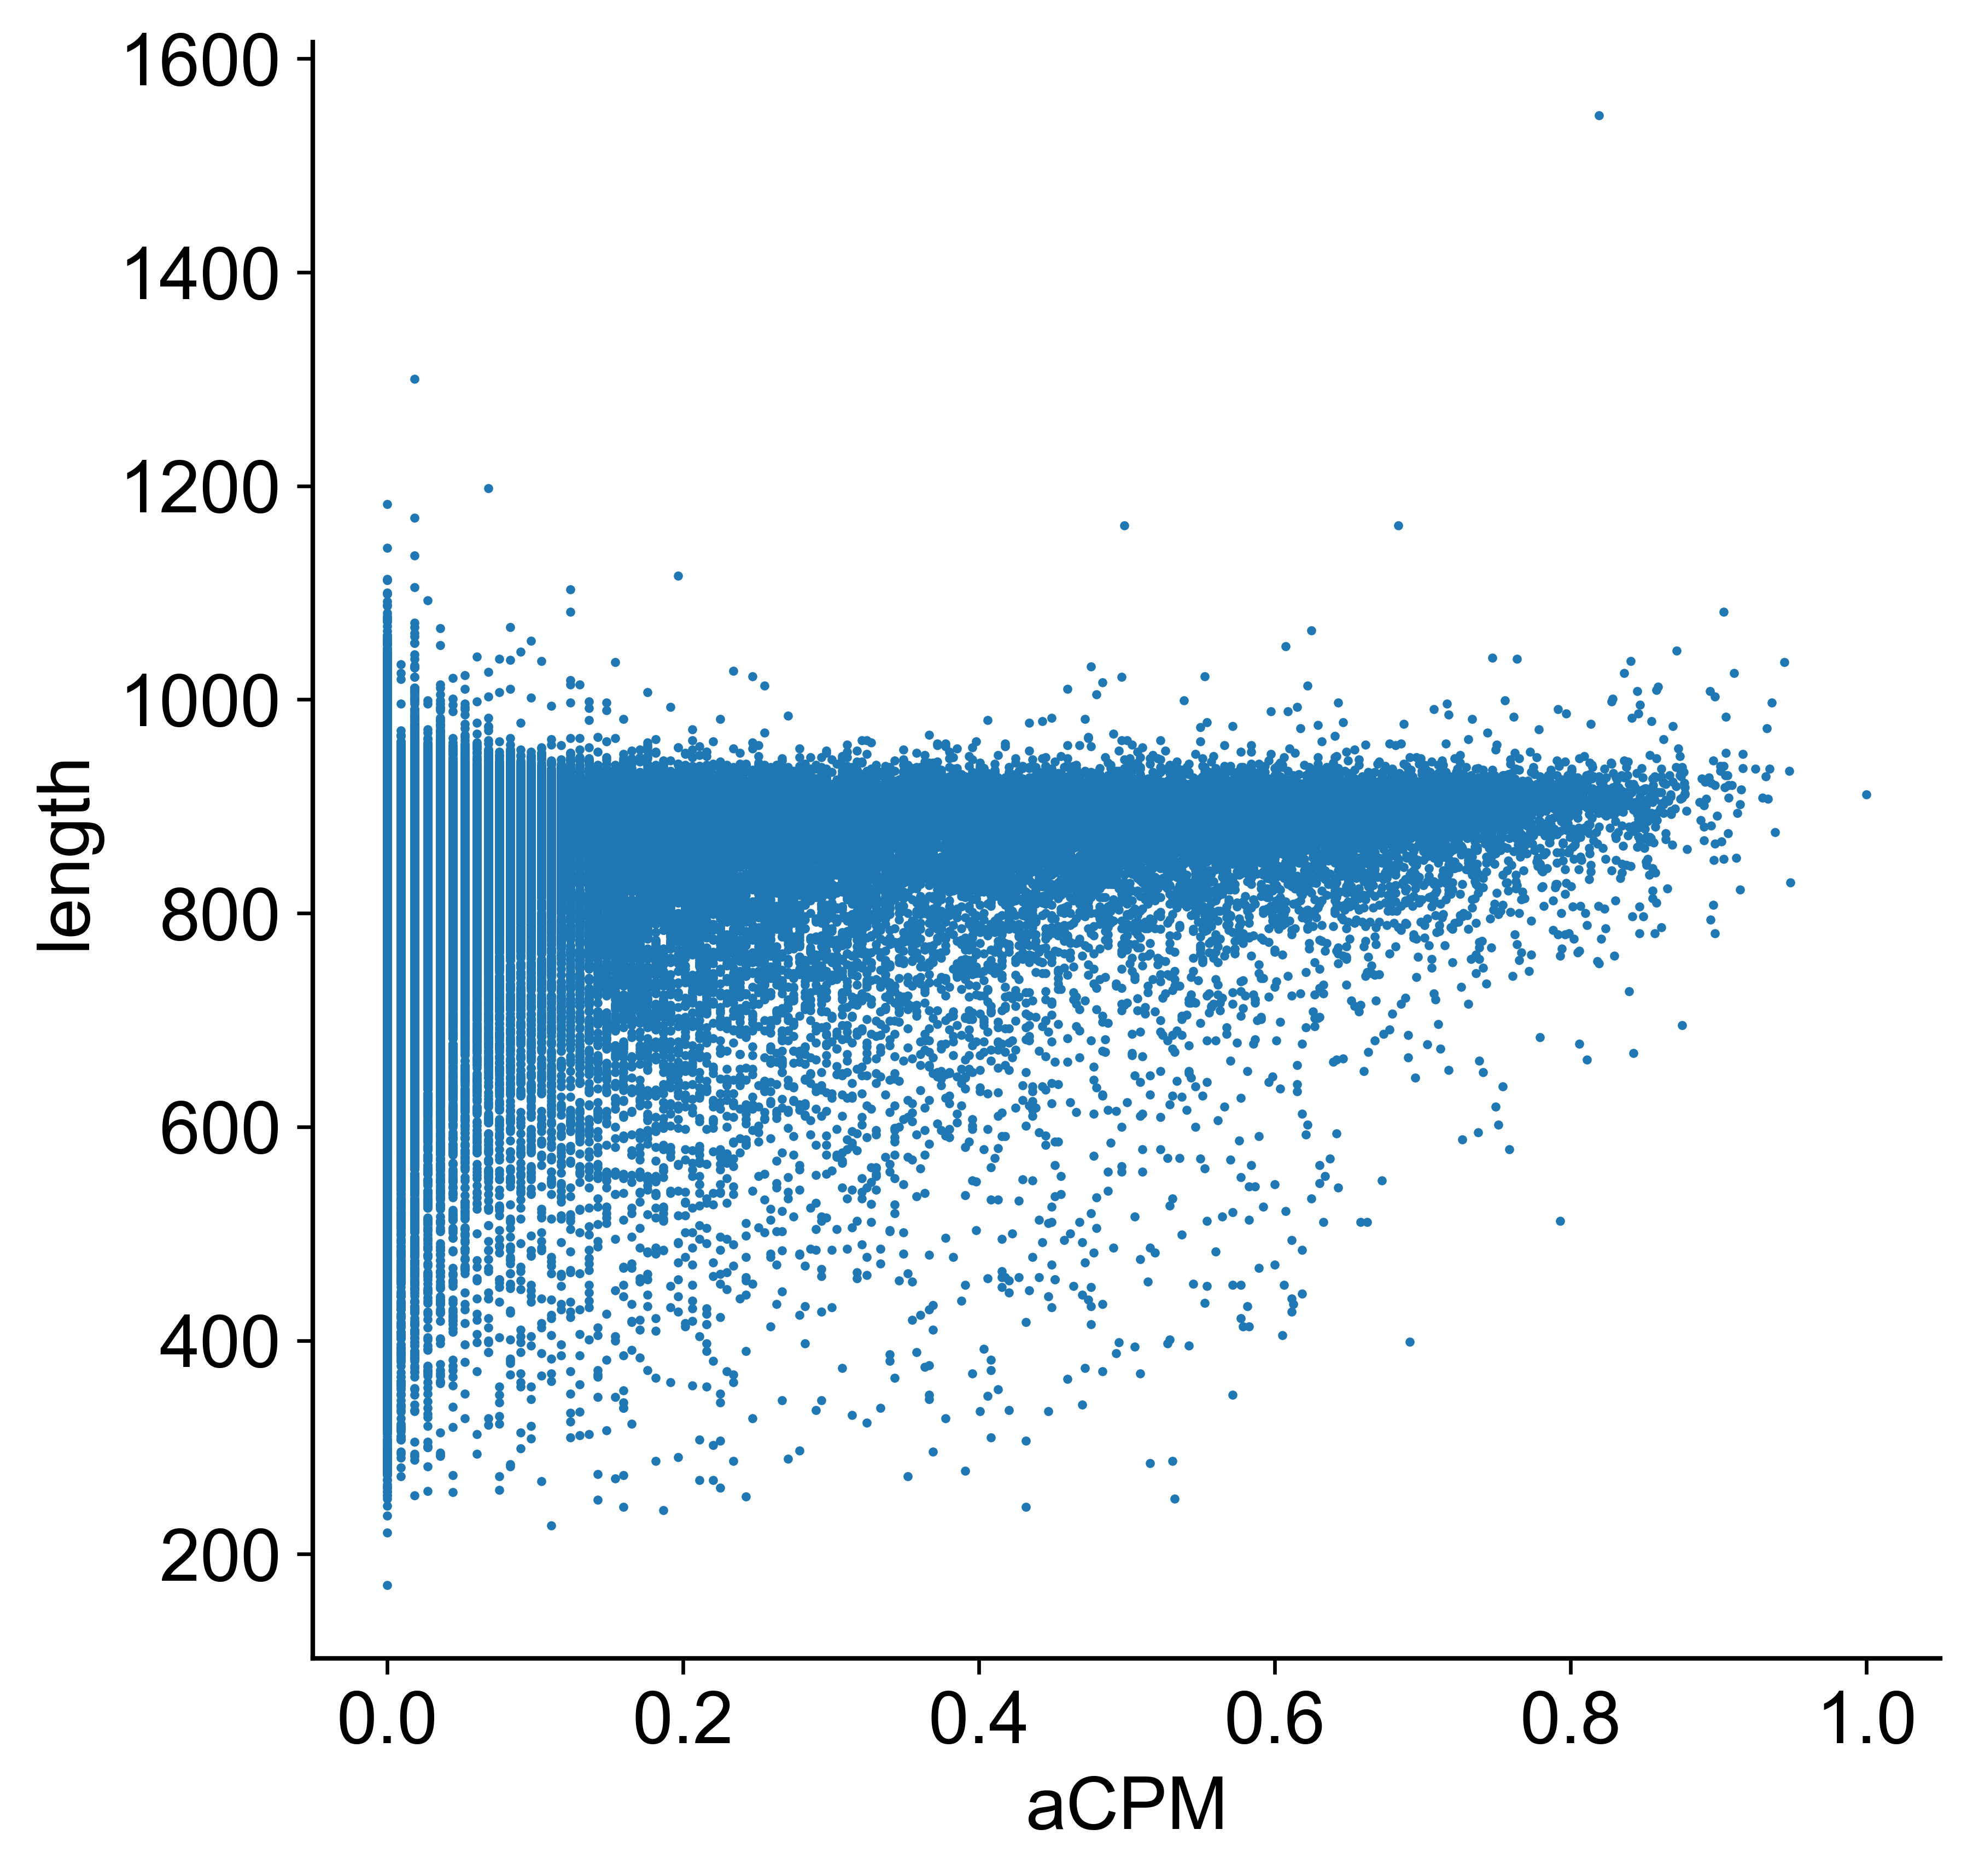

In [20]:
peaks['length'] = peaks['End'] - peaks['Start']
peaks.plot(y='length', x='aCPM', kind='scatter', s=1)

In [21]:
peaks

,Chromosome,Start,End,aCPM,length
0,chr1,9790,10675,0.068361,885
1,chr1,180599,181702,0.123942,1103
2,chr1,191168,192093,0.018614,925
3,chr1,267565,268455,0.018614,890
4,chr1,270876,271770,0.000000,894
...,...,...,...,...,...
143820,chrX,155896411,155896852,0.000000,441
143821,chrX,155966624,155967524,0.000000,900
143822,chrX,155997155,155998067,0.117535,912
143823,chrX,156024967,156025615,0.018614,648


Now let's save the RNA csv files.

In [22]:
# %%
def get_rna_for_cell_type(rna: snap.AnnData, cell_type: str):
    """
    Get the rna for a given cell type.
    """
    counts = rna[rna.obs.cell_type == cell_type].X.sum(0)
    counts = np.log10(counts / counts.sum() * 1e6 + 1)
    counts = np.array(counts).flatten()
    rna_tpm = pd.DataFrame(counts, columns=['TPM'])
    rna_tpm['gene_name'] = rna.var.index
    return rna_tpm[['gene_name', 'TPM']].sort_values(by='gene_name', ascending=True)

In [23]:
#%%
for cell_type in celltype_for_modeling:
    rna_tpm = get_rna_for_cell_type(ad_rna, cell_type)
    rna_tpm.to_csv(f'{cell_type.replace(" ", "_").lower()}.rna.csv', index=False)

## 3. Query motifs and save data as zarr files.

In [24]:
# NOTE: tabix has to be >= 1.17
! tabix --version

tabix (htslib) 1.21
Copyright (C) 2024 Genome Research Ltd.


In [25]:
import os
from pathlib import Path

from gcell._settings import get_setting
from preprocess_utils import (
    add_atpm,
    add_exp,
    create_peak_motif,
    download_motif,
    get_motif,
    query_motif,
)

annotation_dir = Path(get_setting('annotation_dir'))
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/xf2217/.gcell_data/annotations


### Download motif bed file

This will download the non-redundant motif scanning results to `annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz"`.

In [26]:
motif_bed_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz"
motif_bed_index_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz.tbi"


if (
    motif_bed_url
    and motif_bed_index_url
    and not (
        (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz").exists()
        or (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz.tbi").exists()
    )
):
    download_motif(motif_bed_url, motif_bed_index_url, motif_dir=annotation_dir)
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")
else:
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")

### Query motif

In [ ]:
peak_bed = "cd4_naive.atac.bed" # since all cell types share the same peak set, when querying motifs, we can just use one cell type to query motifs.
peaks_motif = query_motif(peak_bed, motif_bed)
get_motif_output = get_motif(peak_bed, peaks_motif)


## 4. Create peak motif zarr file
Create a peak x motif matrix stored in a zarr file. If you are working on multiple cell types with the same peak set, you can use the same peak bed and zarr file for all cell types.

In [ ]:
create_peak_motif(get_motif_output, "pbmc10k_multiome.zarr", peak_bed) # all cell types will later be added to the same zarr file as we use the same peak set.


### Add aCPM data to region x motif matrix
For each cell type, we will save it's aCPM values to the `pbmc10k_multiome.zarr/atpm/{celltype}/` folder

In [33]:
# CD14 Mono number of cells: 2551, library size: 62039712
# CD16 Mono number of cells: 442, library size: 10504281
# CD4 Naive number of cells: 1382, library size: 29601700
# CD4 TCM number of cells: 1113, library size: 24745884
# CD4 TEM number of cells: 286, library size: 6965094
# CD8 Naive number of cells: 1353, library size: 30763516
# CD8 TEM_1 number of cells: 322, library size: 7209424
# CD8 TEM_2 number of cells: 315, library size: 6378479
# Intermediate B number of cells: 300, library size: 8366581
# MAIT number of cells: 130, library size: 3290943
# Memory B number of cells: 298, library size: 7267452
# NK number of cells: 403, library size: 8665433
# Naive B number of cells: 125, library size: 3618917
# Treg number of cells: 157, library size: 3135736
# cDC number of cells: 180, library size: 6102032
# gdT number of cells: 143, library size: 3106695

celltype_for_modeling = [
    'cd14_mono',
    'cd16_mono',
    'cd4_naive',
    'cd4_tcm',
    'cd4_tem',
    'cd8_naive',
    'cd8_tem_1',
    'cd8_tem_2',
    'intermediate_b',
    'mait',
    'memory_b',
    'naive_b',
    'treg',
    'cdc',
    'gdt',
    'nk',
 ]

In [34]:
for cell_type in celltype_for_modeling:
    add_atpm(
        "pbmc10k_multiome.zarr",
        f"{cell_type}.atac.bed",
        cell_type,
    )

       Chromosome      Start        End      aTPM                      Name
0            chr1       9790      10675  0.016197           chr1:9790-10675
1            chr1     180599     181702  0.031115        chr1:180599-181702
2            chr1     191168     192093  0.032358        chr1:191168-192093
3            chr1     267565     268455  0.097888        chr1:267565-268455
4            chr1     270876     271770  0.045691        chr1:270876-271770
...           ...        ...        ...       ...                       ...
143820       chrX  155896411  155896852  0.011344  chrX:155896411-155896852
143821       chrX  155966624  155967524  0.007312  chrX:155966624-155967524
143822       chrX  155997155  155998067  0.002764  chrX:155997155-155998067
143823       chrX  156024967  156025615  0.005955  chrX:156024967-156025615
143824       chrX  156030098  156030882  0.034008  chrX:156030098-156030882

[143825 rows x 5 columns]


       Chromosome      Start        End      aTPM                      Name
0            chr1       9790      10675  0.029071           chr1:9790-10675
1            chr1     180599     181702  0.045324        chr1:180599-181702
2            chr1     191168     192093  0.017758        chr1:191168-192093
3            chr1     267565     268455  0.075543        chr1:267565-268455
4            chr1     270876     271770  0.045324        chr1:270876-271770
...           ...        ...        ...       ...                       ...
143820       chrX  155896411  155896852  0.000000  chrX:155896411-155896852
143821       chrX  155966624  155967524  0.000000  chrX:155966624-155967524
143822       chrX  155997155  155998067  0.011948  chrX:155997155-155998067
143823       chrX  156024967  156025615  0.000000  chrX:156024967-156025615
143824       chrX  156030098  156030882  0.060791  chrX:156030098-156030882

[143825 rows x 5 columns]
       Chromosome      Start        End      aTPM            

### Add expression and TSS data to region x motif matrix

In [35]:
for cell_type in celltype_for_modeling:
    add_exp(
        "pbmc10k_multiome.zarr",
        f"{cell_type}.rna.csv",
        f"{cell_type}.atac.bed",
        cell_type,
        assembly="hg38",
        version=44,
        extend_bp=300, # extend TSS region to 300bp upstream and downstream when overlapping with peaks
    id_or_name="gene_name", # use gene_name or gene_id to match the gene expression data, checkout your rna.csv file column names, should be either [gene_name, TPM] or [gene_id, TPM]
)

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/tutorials/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["index", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/home/xf2217/Projects/get_model.worktrees/refactor_with_hydra/tutorials/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

### Clean up intermediate files

In [45]:
for file in [peaks_motif, get_motif_output]:
    os.remove(file)

This has conclude the data processing steps.